## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.


Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course \


Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [11]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [12]:
# (re-)load layers
%run modules.ipynb

<>:2: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_248767/2367876760.py:2: SyntaxWarning: invalid escape sequence '\g'
  """


# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

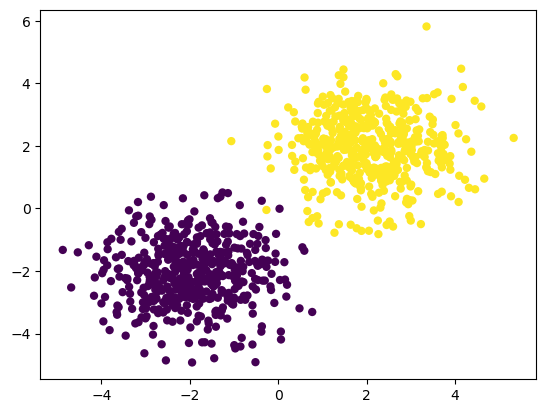

In [13]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [14]:

net = Sequential()
net.add(Linear(2, 16))
net.add(ReLU())
net.add(Linear(16, 2))
net.add(LogSoftMax())
criterion = ClassNLLCriterion()
print(net)



Linear 2 -> 16
ReLU
Linear 16 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [15]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 10
batch_size = 256

In [16]:

# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

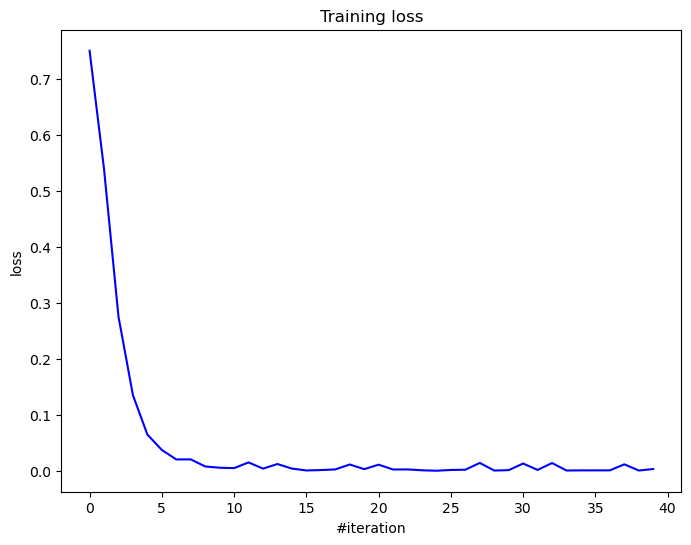

Current loss: 0.003088


In [17]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

In [18]:
output = net.forward(X)
predictions = np.argmax(output, axis=1)
true_labels = np.argmax(Y, axis=1)

# Вычисление точности
accuracy = np.mean(predictions == true_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 99.90%


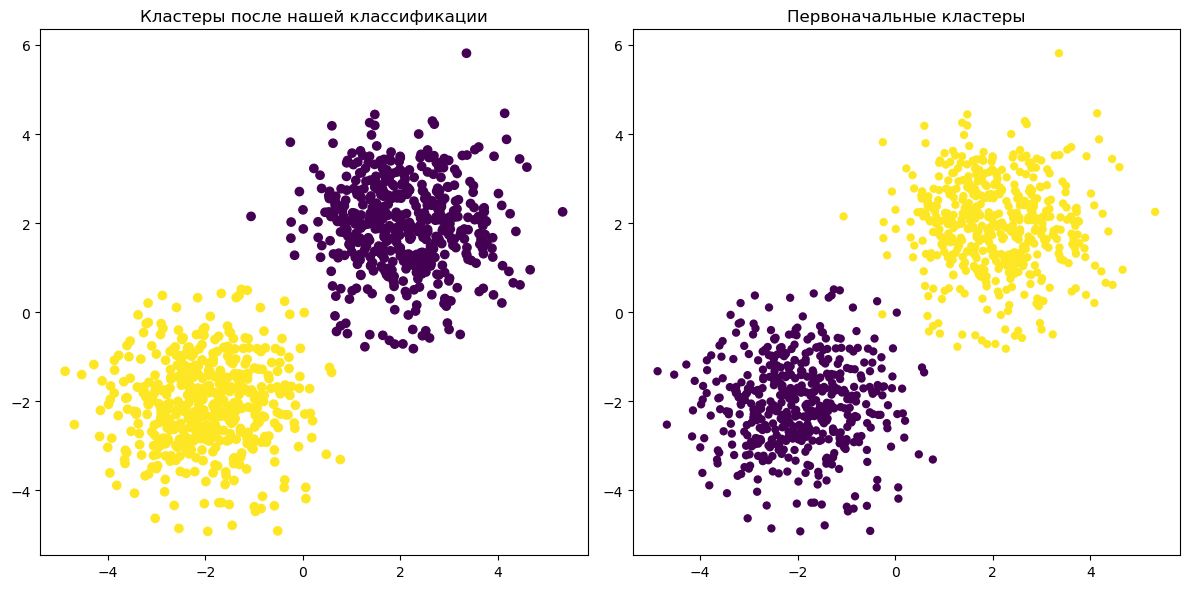

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Первый scatterplot
ax1.scatter(X[:, 0], X[:, 1], c=predictions)
ax1.set_title("Кластеры после нашей классификации")


# Второй scatterplot
ax2.scatter(X[:, 0], X[:, 1], c = Y[:,0], edgecolors='none')
ax2.set_title("Первоначальные кластеры")


# Отображаем графики
plt.tight_layout()
plt.show()

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [20]:
# !wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

In [21]:
import numpy as np
import struct
from array import array


def read_images_labels(images_filepath, labels_filepath):        
    labels = []
    with open(labels_filepath, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
        labels = array("B", file.read())        
    
    with open(images_filepath, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        if magic != 2051:
            raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
        image_data = array("B", file.read())        
    images = []
    for i in range(size):
        images.append([0] * rows * cols)
    for i in range(size):
        img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
        img = img.reshape(28, 28)
        images[i][:] = img            
    
    return images, labels
    

In [22]:
train_images, train_labels = read_images_labels("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
test_images, test_labels = read_images_labels("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")

X_train, X_val = train_images[:-10000], test_images[-10000:]
y_train, y_val = train_labels[:-10000], test_labels[-10000:]


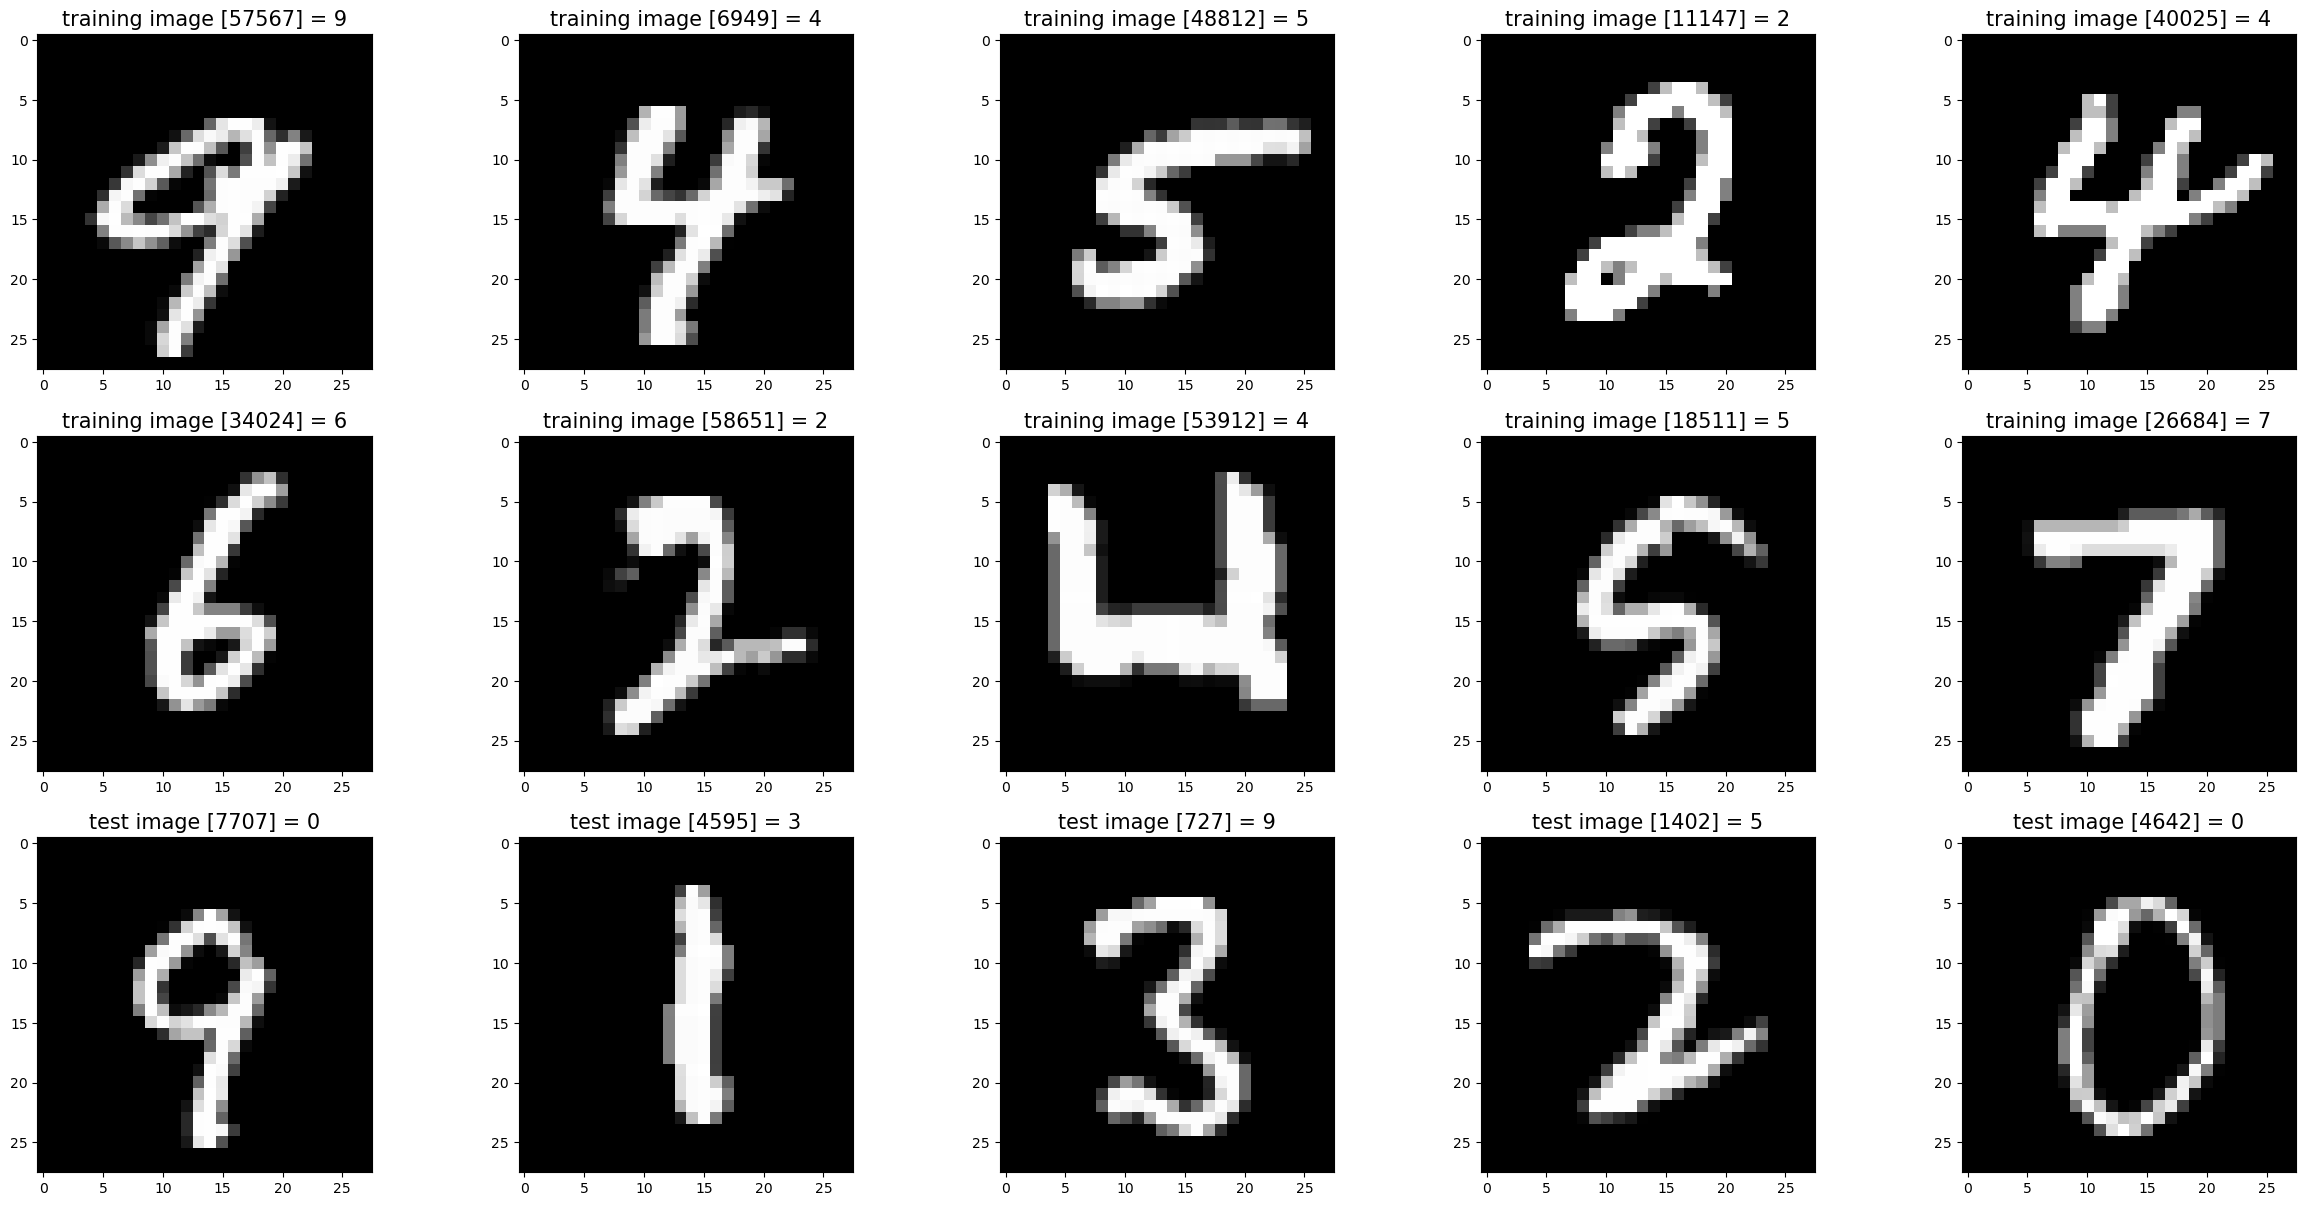

In [23]:
#
# Verify Reading Dataset via MnistDataloader class
#
import random
import matplotlib.pyplot as plt

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1


images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(train_images[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(train_labels[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(test_images[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(train_labels[r]))    

show_images(images_2_show, titles_2_show)

One-hot encode the labels first.

In [67]:
# Your code goes here. ################################################

X_train = np.array(train_images) / 255
X_val = np.array(test_images) / 255
y_train = np.array(train_labels)
y_val = np.array(test_labels)


def one_hot(labels, num_classes=10):
    ohe = np.zeros((labels.size, num_classes))
    ohe[np.arange(labels.size), labels] = 1
    return ohe



y_train = one_hot(y_train)
y_val = one_hot(y_val)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [25]:
# Модель с активацией ReLU
model_relu = Sequential()
model_relu.add(Flatten())
model_relu.add(Linear(784, 100))
model_relu.add(ReLU())
model_relu.add(Linear(100, 10))
model_relu.add(LogSoftMax())
print("Структура модели:  \n", model_relu)

Структура модели:  
 Flatten
Linear 784 -> 100
ReLU
Linear 100 -> 10
LogSoftMax



In [26]:
# Модель с активацией ReLU для бача другого размера
model_relu3 = Sequential()
model_relu3.add(Flatten())
model_relu3.add(Linear(784, 100))
model_relu3.add(ReLU())
model_relu3.add(Linear(100, 10))
model_relu3.add(LogSoftMax())
print("Структура модели:  \n", model_relu3)

Структура модели:  
 Flatten
Linear 784 -> 100
ReLU
Linear 100 -> 10
LogSoftMax



In [27]:
# Модель с активацией ReLU и BatchNorm
model_relu_bn = Sequential()
model_relu_bn.add(Flatten())
model_relu_bn.add(Linear(784, 100))
model_relu_bn.add(BatchNormalization())
model_relu_bn.add(ChannelwiseScaling(100))
model_relu_bn.add(ReLU())
model_relu_bn.add(Linear(100, 10))
model_relu_bn.add(LogSoftMax())
print("Структура модели:  \n", model_relu_bn)


Структура модели:  
 Flatten
Linear 784 -> 100
BatchNormalization
ChannelwiseScaling
ReLU
Linear 100 -> 10
LogSoftMax



In [28]:
# Модель с активацией ReLU и BatchNorm для другого размера бача
model_relu_bn1 = Sequential()
model_relu_bn1.add(Flatten())
model_relu_bn1.add(Linear(784, 100))
model_relu_bn1.add(BatchNormalization())
model_relu_bn1.add(ChannelwiseScaling(100))
model_relu_bn1.add(ReLU())
model_relu_bn1.add(Linear(100, 10))
model_relu_bn1.add(LogSoftMax())
print("Структура модели:  \n", model_relu_bn1)

Структура модели:  
 Flatten
Linear 784 -> 100
BatchNormalization
ChannelwiseScaling
ReLU
Linear 100 -> 10
LogSoftMax



In [29]:
# Модель с активацией ELU с альфа 1
model_elu = Sequential()
model_elu.add(Flatten())
model_elu.add(Linear(784, 100))
model_elu.add(ELU(alpha=1))
model_elu.add(Linear(100, 10))
model_elu.add(LogSoftMax())
print("Структура модели:  \n", model_elu)


Структура модели:  
 Flatten
Linear 784 -> 100
ELU
Linear 100 -> 10
LogSoftMax



In [30]:
# Модель с активацией ELU с альфа 0.5
model_elu1 = Sequential()
model_elu1.add(Flatten())
model_elu1.add(Linear(784, 100))
model_elu1.add(ELU(alpha=0.5))
model_elu1.add(Linear(100, 10))
model_elu1.add(LogSoftMax())
print("Структура модели:  \n", model_elu1)

Структура модели:  
 Flatten
Linear 784 -> 100
ELU
Linear 100 -> 10
LogSoftMax



In [31]:
# Модель с активацией LeakyReLU
model_leaky = Sequential()
model_leaky.add(Flatten())
model_leaky.add(Linear(784, 100))
model_leaky.add(LeakyReLU())
model_leaky.add(Linear(100, 10))
model_leaky.add(LogSoftMax())
print("Структура модели:  \n", model_leaky)

Структура модели:  
 Flatten
Linear 784 -> 100
LeakyReLU
Linear 100 -> 10
LogSoftMax



In [32]:
# Модель с активацией SoftPlus
model_softplus = Sequential()
model_softplus.add(Flatten())
model_softplus.add(Linear(784, 100))
model_softplus.add(SoftPlus())
model_softplus.add(Linear(100, 10))
model_softplus.add(LogSoftMax())
print("Структура модели: \n",model_softplus)

Структура модели: 
 Flatten
Linear 784 -> 100
SoftPlus
Linear 100 -> 10
LogSoftMax



In [33]:
# Модель с активацией ReLU Dropout BatchNorm
model_relu_final = Sequential()
model_relu_final.add(Flatten())
model_relu_final.add(Linear(784, 392))
model_relu_final.add(BatchNormalization())
model_relu_final.add(ChannelwiseScaling(392))
model_relu_final.add(ReLU())  
model_relu_final.add(Linear(392, 392))
model_relu_final.add(BatchNormalization())
model_relu_final.add(ChannelwiseScaling(392))
model_relu_final.add(Dropout(0.5))
model_relu_final.add(Linear(392, 100))
model_relu_final.add(BatchNormalization())
model_relu_final.add(ChannelwiseScaling(100))
model_relu_final.add(ReLU())
model_relu_final.add(Linear(100, 10))
model_relu_final.add(LogSoftMax())
print("Структура модели:  \n", model_relu_final)



Структура модели:  
 Flatten
Linear 784 -> 392
BatchNormalization
ChannelwiseScaling
ReLU
Linear 392 -> 392
BatchNormalization
ChannelwiseScaling
Dropout
Linear 392 -> 100
BatchNormalization
ChannelwiseScaling
ReLU
Linear 100 -> 10
LogSoftMax



In [34]:
# Еще модель с активацией ReLU Dropout BatchNorm с другими линейными слоями

model_relu_final1 = Sequential()
model_relu_final1.add(Flatten())
model_relu_final1.add(Linear(784, 256))
model_relu_final1.add(BatchNormalization())
model_relu_final1.add(ChannelwiseScaling(256))
model_relu_final1.add(ReLU())  
model_relu_final1.add(Dropout(0.5))
model_relu_final1.add(Linear(256, 128))
model_relu_final1.add(BatchNormalization())
model_relu_final1.add(ChannelwiseScaling(128))
model_relu_final1.add(ReLU())  
model_relu_final1.add(Dropout(0.5))
model_relu_final1.add(Linear(128, 64))
model_relu_final1.add(BatchNormalization())
model_relu_final1.add(ChannelwiseScaling(64))
model_relu_final1.add(ReLU())
model_relu_final1.add(Linear(64, 10))
model_relu_final1.add(LogSoftMax())
print("Структура модели:  \n", model_relu_final1)

Структура модели:  
 Flatten
Linear 784 -> 256
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 256 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 128 -> 64
BatchNormalization
ChannelwiseScaling
ReLU
Linear 64 -> 10
LogSoftMax



In [35]:
# Еще модель с активацией ReLU Dropout BatchNorm с большим количеством слоев
model_relu_final2 = Sequential()

model_relu_final2.add(Flatten())

model_relu_final2.add(Linear(784, 512))
model_relu_final2.add(BatchNormalization())
model_relu_final2.add(ChannelwiseScaling(512))
model_relu_final2.add(ReLU())
model_relu_final2.add(Dropout(0.2))  # Меньший dropout в начале

model_relu_final2.add(Linear(512, 512))
model_relu_final2.add(BatchNormalization())
model_relu_final2.add(ChannelwiseScaling(512))
model_relu_final2.add(ReLU())
model_relu_final2.add(Dropout(0.3))

model_relu_final2.add(Linear(512, 256))
model_relu_final2.add(BatchNormalization())
model_relu_final2.add(ChannelwiseScaling(256))
model_relu_final2.add(ReLU())
model_relu_final2.add(Dropout(0.4))

model_relu_final2.add(Linear(256, 128))
model_relu_final2.add(BatchNormalization())
model_relu_final2.add(ChannelwiseScaling(128))
model_relu_final2.add(ReLU())
model_relu_final2.add(Dropout(0.5))


model_relu_final2.add(Linear(128, 10))
model_relu_final2.add(LogSoftMax())

print("Структура модели:  \n", model_relu_final2)

Структура модели:  
 Flatten
Linear 784 -> 512
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 512 -> 512
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 512 -> 256
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 256 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 128 -> 10
LogSoftMax



In [36]:
# Модель с активацией ReLU для другого оптимизатора
model_relu2 = Sequential()
model_relu2.add(Flatten())
model_relu2.add(Linear(784, 100))
model_relu2.add(ReLU())  
model_relu2.add(Linear(100, 10))
model_relu2.add(LogSoftMax())
print("Структура модели:  \n", model_relu2)


Структура модели:  
 Flatten
Linear 784 -> 100
ReLU
Linear 100 -> 10
LogSoftMax



In [37]:
def train_mnist(train_x, train_y, test_x, test_y, model, n_epoch=10, batch_size=128, learning_rate=1e-1, beta1=0.9, beta2=0.999, EPS=1e-8, lr_decay=1):
    """
    Обучает классификатор для MNIST. train_y и test_y уже в one-hot формате.

    Args:
        train_x: тренировочные данные (изображения).
        train_y: тренировочные метки (one-hot).
        test_x: тестовые данные (изображения).
        test_y: тестовые метки (one-hot).
        n_epoch: количество эпох обучения.
        batch_size: размер батча.
        learning_rate: скорость обучения.
        beta1: beta1 для Adam оптимизатора.
        beta2: beta2 для Adam оптимизатора.
        EPS: малое значение для предотвращения деления на ноль.

    Returns:
        Sequential: обученный классификатор.
        test_losses: список значений потерь на тестовой выборке.
        test_accuracies: список значений точности на тестовой выборке.
    """

    # 2. Создаем критерий
    criterion = ClassNLLCriterion()

    # 3. Настраиваем оптимизатор
    optimizer_config = {
        'learning_rate': learning_rate,
        'beta1': beta1,
        'beta2': beta2,
        'epsilon': EPS
    }
    optimizer_state = {}

    # Для хранения метрик обучения
    test_losses = []
    test_accuracies = []


    # 4. Обучаем модель
    for epoch in range(n_epoch):
        model.train()

        # Изменяем скорость обучения каждые 6 эпох
        if lr_decay != 1:
            if (epoch + 1) % 6 == 0:
                optimizer_config['learning_rate'] *= lr_decay
                print(f"Learning rate decreased to {optimizer_config['learning_rate']}")
        for x_batch, y_batch_onehot in get_batches((train_x, train_y), batch_size):
            # Прямой проход
            predictions = model.forward(x_batch)

            # Вычисляем потери
            loss = criterion.forward(predictions, y_batch_onehot)

            # Обратный проход
            grad_output = criterion.backward(predictions, y_batch_onehot)
            model.backward(x_batch, grad_output)

            # Обновляем параметры модели
            adam_optimizer(model.getParameters(), model.getGradParameters(), optimizer_config, optimizer_state)
            model.zeroGradParameters()

        # Вычисляем потери и точность на тестовой выборке
        model.evaluate()
        test_predictions = model.forward(test_x)
        test_loss = criterion.forward(test_predictions, test_y)
        accuracy = np.mean(np.argmax(test_predictions, axis=1) == np.argmax(test_y, axis=1))

        # Сохраняем метрики
        test_losses.append(test_loss)
        test_accuracies.append(accuracy)

        print(f"Epoch {epoch + 1}/{n_epoch}, Test loss: {test_loss:.4f}, Test : {accuracy:.4f}")

    return model, test_losses, test_accuracies

In [38]:
def train_mnist_sgd(train_x, train_y, test_x, test_y, model, n_epoch=10, batch_size=128, learning_rate=1e-1, momentum=0.9):
    """
    Обучает классификатор для MNIST. train_y и test_y уже в one-hot формате.

    Args:
        train_x: тренировочные данные (изображения).
        train_y: тренировочные метки (one-hot).
        test_x: тестовые данные (изображения).
        test_y: тестовые метки (one-hot).
        n_epoch: количество эпох обучения.
        batch_size: размер батча.
        learning_rate: скорость обучения.
        momentum: параметр для SDG оптимизатора


    Returns:
        Sequential: обученный классификатор.
        test_losses: список значений потерь на тестовой выборке.
        test_accuracies: список значений точности на тестовой выборке.
    """

    # 2. Создаем критерий
    criterion = ClassNLLCriterion()

    # 3. Настраиваем оптимизатор
    optimizer_config = {
        'learning_rate': learning_rate,
        'momentum': momentum,
    }
    optimizer_state = {}

    # Для хранения метрик обучения
    test_losses = []
    test_accuracies = []

    # 4. Обучаем модель
    for epoch in range(n_epoch):
        model.train()
        for x_batch, y_batch_onehot in get_batches((train_x, train_y), batch_size):
            # Прямой проход
            predictions = model.forward(x_batch)

            # Вычисляем потери
            loss = criterion.forward(predictions, y_batch_onehot)

            # Обратный проход
            grad_output = criterion.backward(predictions, y_batch_onehot)
            model.backward(x_batch, grad_output)

            # Обновляем параметры модели
            sgd_momentum(model.getParameters(), model.getGradParameters(), optimizer_config, optimizer_state)
            model.zeroGradParameters()

        # Вычисляем потери и точность на тестовой выборке
            model.evaluate()
            test_predictions = model.forward(test_x)
            test_loss = criterion.forward(test_predictions, test_y) 
            accuracy = np.mean(np.argmax(test_predictions, axis=1) == np.argmax(test_y, axis=1))

        # Сохраняем метрики
        test_losses.append(test_loss)
        test_accuracies.append(accuracy)

        print(f"Epoch {epoch + 1}/{n_epoch}, Test loss: {test_loss:.4f}, Test : {accuracy:.4f}")

    return model, test_losses, test_accuracies

In [39]:
n_epoch = 25
batch_size = 2500
lr = 3e-3

In [40]:
print('Обучение модели с активацией ReLU с помощью Adam optimazier')
trained_model_relu, test_losses_relu, test_accuracies_relu = train_mnist(X_train, y_train, X_val, y_val,model_relu, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели с активацией ReLU с помощью Adam optimazier


Epoch 1/25, Test loss: 0.3960, Test : 0.8865
Epoch 2/25, Test loss: 0.2972, Test : 0.9148
Epoch 3/25, Test loss: 0.2545, Test : 0.9274
Epoch 4/25, Test loss: 0.2238, Test : 0.9369
Epoch 5/25, Test loss: 0.2005, Test : 0.9424
Epoch 6/25, Test loss: 0.1835, Test : 0.9474
Epoch 7/25, Test loss: 0.1718, Test : 0.9494
Epoch 8/25, Test loss: 0.1560, Test : 0.9542
Epoch 9/25, Test loss: 0.1492, Test : 0.9580
Epoch 10/25, Test loss: 0.1385, Test : 0.9598
Epoch 11/25, Test loss: 0.1328, Test : 0.9621
Epoch 12/25, Test loss: 0.1240, Test : 0.9637
Epoch 13/25, Test loss: 0.1218, Test : 0.9654
Epoch 14/25, Test loss: 0.1167, Test : 0.9668
Epoch 15/25, Test loss: 0.1132, Test : 0.9670
Epoch 16/25, Test loss: 0.1081, Test : 0.9675
Epoch 17/25, Test loss: 0.1049, Test : 0.9694
Epoch 18/25, Test loss: 0.1032, Test : 0.9701
Epoch 19/25, Test loss: 0.1017, Test : 0.9705
Epoch 20/25, Test loss: 0.0984, Test : 0.9709
Epoch 21/25, Test loss: 0.0990, Test : 0.9714
Epoch 22/25, Test loss: 0.0934, Test : 0.97

In [41]:
print('Обучение модели с активацией ReLU с помощью Adam optimazier 500')
trained_model_relu3, test_losses_relu3, test_accuracies_relu3 = train_mnist(X_train, y_train, X_val, y_val,model_relu3, n_epoch=n_epoch, batch_size=500, learning_rate=lr)

Обучение модели с активацией ReLU с помощью Adam optimazier 500
Epoch 1/25, Test loss: 0.2443, Test : 0.9310
Epoch 2/25, Test loss: 0.1843, Test : 0.9456
Epoch 3/25, Test loss: 0.1444, Test : 0.9577
Epoch 4/25, Test loss: 0.1195, Test : 0.9634
Epoch 5/25, Test loss: 0.1104, Test : 0.9669
Epoch 6/25, Test loss: 0.0970, Test : 0.9711
Epoch 7/25, Test loss: 0.0918, Test : 0.9716
Epoch 8/25, Test loss: 0.0901, Test : 0.9717
Epoch 9/25, Test loss: 0.0839, Test : 0.9752
Epoch 10/25, Test loss: 0.0826, Test : 0.9752
Epoch 11/25, Test loss: 0.0831, Test : 0.9748
Epoch 12/25, Test loss: 0.0784, Test : 0.9758
Epoch 13/25, Test loss: 0.0814, Test : 0.9772
Epoch 14/25, Test loss: 0.0776, Test : 0.9784
Epoch 15/25, Test loss: 0.0836, Test : 0.9768
Epoch 16/25, Test loss: 0.0828, Test : 0.9767
Epoch 17/25, Test loss: 0.0852, Test : 0.9780
Epoch 18/25, Test loss: 0.0863, Test : 0.9753
Epoch 19/25, Test loss: 0.0851, Test : 0.9766
Epoch 20/25, Test loss: 0.0885, Test : 0.9758
Epoch 21/25, Test loss: 0

In [42]:
print('Обучение модели с активацией ReLU и BatchNormalization')
trained_model_relu_bn, test_losses_relu_bn, test_accuracies_relu_bn = train_mnist(X_train, y_train, X_val, y_val,model_relu_bn, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели с активацией ReLU и BatchNormalization
Epoch 1/25, Test loss: 1.5946, Test : 0.8452
Epoch 2/25, Test loss: 0.7292, Test : 0.8907
Epoch 3/25, Test loss: 0.4009, Test : 0.9112
Epoch 4/25, Test loss: 0.3110, Test : 0.9196
Epoch 5/25, Test loss: 0.2706, Test : 0.9293
Epoch 6/25, Test loss: 0.2417, Test : 0.9352
Epoch 7/25, Test loss: 0.2239, Test : 0.9396
Epoch 8/25, Test loss: 0.2016, Test : 0.9461
Epoch 9/25, Test loss: 0.1884, Test : 0.9491
Epoch 10/25, Test loss: 0.1746, Test : 0.9519
Epoch 11/25, Test loss: 0.1642, Test : 0.9567
Epoch 12/25, Test loss: 0.1570, Test : 0.9565
Epoch 13/25, Test loss: 0.1474, Test : 0.9597
Epoch 14/25, Test loss: 0.1412, Test : 0.9619
Epoch 15/25, Test loss: 0.1389, Test : 0.9607
Epoch 16/25, Test loss: 0.1330, Test : 0.9637
Epoch 17/25, Test loss: 0.1279, Test : 0.9650
Epoch 18/25, Test loss: 0.1239, Test : 0.9655
Epoch 19/25, Test loss: 0.1196, Test : 0.9664
Epoch 20/25, Test loss: 0.1172, Test : 0.9666
Epoch 21/25, Test loss: 0.1130, Te

In [43]:
print('Обучение модели с активацией ReLU и BatchNormalization batchsize 500')
trained_model_relu_bn1, test_losses_relu_bn1, test_accuracies_relu_bn1 = train_mnist(X_train, y_train, X_val, y_val,model_relu_bn1, n_epoch=n_epoch, batch_size=500, learning_rate=lr)

Обучение модели с активацией ReLU и BatchNormalization batchsize 500
Epoch 1/25, Test loss: 0.3043, Test : 0.9182
Epoch 2/25, Test loss: 0.2078, Test : 0.9417
Epoch 3/25, Test loss: 0.1661, Test : 0.9531
Epoch 4/25, Test loss: 0.1419, Test : 0.9596
Epoch 5/25, Test loss: 0.1217, Test : 0.9670
Epoch 6/25, Test loss: 0.1094, Test : 0.9704
Epoch 7/25, Test loss: 0.1016, Test : 0.9696
Epoch 8/25, Test loss: 0.0933, Test : 0.9732
Epoch 9/25, Test loss: 0.0909, Test : 0.9738
Epoch 10/25, Test loss: 0.0913, Test : 0.9726
Epoch 11/25, Test loss: 0.0890, Test : 0.9733
Epoch 12/25, Test loss: 0.0881, Test : 0.9737
Epoch 13/25, Test loss: 0.0879, Test : 0.9741
Epoch 14/25, Test loss: 0.0880, Test : 0.9749
Epoch 15/25, Test loss: 0.0884, Test : 0.9735
Epoch 16/25, Test loss: 0.0862, Test : 0.9753
Epoch 17/25, Test loss: 0.0896, Test : 0.9751
Epoch 18/25, Test loss: 0.0923, Test : 0.9756
Epoch 19/25, Test loss: 0.0936, Test : 0.9756
Epoch 20/25, Test loss: 0.0921, Test : 0.9756
Epoch 21/25, Test lo

In [44]:
print('Обучение модели с активацией ELU')
trained_model_elu, test_losses_elu, test_accuracies_elu = train_mnist(X_train, y_train, X_val, y_val, model_elu, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели с активацией ELU
Epoch 1/25, Test loss: 0.3816, Test : 0.8887
Epoch 2/25, Test loss: 0.2973, Test : 0.9153
Epoch 3/25, Test loss: 0.2625, Test : 0.9256
Epoch 4/25, Test loss: 0.2367, Test : 0.9321
Epoch 5/25, Test loss: 0.2129, Test : 0.9385
Epoch 6/25, Test loss: 0.1937, Test : 0.9433
Epoch 7/25, Test loss: 0.1756, Test : 0.9488
Epoch 8/25, Test loss: 0.1592, Test : 0.9530
Epoch 9/25, Test loss: 0.1472, Test : 0.9578
Epoch 10/25, Test loss: 0.1410, Test : 0.9584
Epoch 11/25, Test loss: 0.1303, Test : 0.9603
Epoch 12/25, Test loss: 0.1223, Test : 0.9624
Epoch 13/25, Test loss: 0.1162, Test : 0.9662
Epoch 14/25, Test loss: 0.1112, Test : 0.9674
Epoch 15/25, Test loss: 0.1060, Test : 0.9683
Epoch 16/25, Test loss: 0.1035, Test : 0.9691
Epoch 17/25, Test loss: 0.0991, Test : 0.9707
Epoch 18/25, Test loss: 0.0974, Test : 0.9712
Epoch 19/25, Test loss: 0.0931, Test : 0.9736
Epoch 20/25, Test loss: 0.0905, Test : 0.9729
Epoch 21/25, Test loss: 0.0903, Test : 0.9729
Epoch 22/2

In [45]:
print('Обучение модели с активацией ELU с другим alpha')
trained_model_elu1, test_losses_elu1, test_accuracies_elu1 = train_mnist(X_train, y_train, X_val, y_val, model_elu1, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели с активацией ELU с другим alpha
Epoch 1/25, Test loss: 0.3883, Test : 0.8917
Epoch 2/25, Test loss: 0.3029, Test : 0.9132
Epoch 3/25, Test loss: 0.2789, Test : 0.9202
Epoch 4/25, Test loss: 0.2528, Test : 0.9274
Epoch 5/25, Test loss: 0.2318, Test : 0.9337
Epoch 6/25, Test loss: 0.2084, Test : 0.9404
Epoch 7/25, Test loss: 0.1897, Test : 0.9452
Epoch 8/25, Test loss: 0.1764, Test : 0.9486
Epoch 9/25, Test loss: 0.1618, Test : 0.9530
Epoch 10/25, Test loss: 0.1489, Test : 0.9571
Epoch 11/25, Test loss: 0.1397, Test : 0.9587
Epoch 12/25, Test loss: 0.1310, Test : 0.9618
Epoch 13/25, Test loss: 0.1232, Test : 0.9644
Epoch 14/25, Test loss: 0.1158, Test : 0.9659
Epoch 15/25, Test loss: 0.1117, Test : 0.9666
Epoch 16/25, Test loss: 0.1086, Test : 0.9673
Epoch 17/25, Test loss: 0.1055, Test : 0.9687
Epoch 18/25, Test loss: 0.1007, Test : 0.9686
Epoch 19/25, Test loss: 0.0975, Test : 0.9703
Epoch 20/25, Test loss: 0.0946, Test : 0.9705
Epoch 21/25, Test loss: 0.0927, Test : 0.

In [46]:
print('Обучение модели с активацией LeakyReLU')
trained_model_leaky, test_losses_leaky, test_accuracies_leaky = train_mnist(X_train, y_train, X_val, y_val,model_leaky, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели с активацией LeakyReLU
Epoch 1/25, Test loss: 0.3954, Test : 0.8857
Epoch 2/25, Test loss: 0.2994, Test : 0.9149
Epoch 3/25, Test loss: 0.2570, Test : 0.9278
Epoch 4/25, Test loss: 0.2290, Test : 0.9353
Epoch 5/25, Test loss: 0.2117, Test : 0.9379
Epoch 6/25, Test loss: 0.1906, Test : 0.9444
Epoch 7/25, Test loss: 0.1756, Test : 0.9488
Epoch 8/25, Test loss: 0.1662, Test : 0.9514
Epoch 9/25, Test loss: 0.1543, Test : 0.9540
Epoch 10/25, Test loss: 0.1447, Test : 0.9579
Epoch 11/25, Test loss: 0.1366, Test : 0.9600
Epoch 12/25, Test loss: 0.1304, Test : 0.9624
Epoch 13/25, Test loss: 0.1275, Test : 0.9618
Epoch 14/25, Test loss: 0.1234, Test : 0.9636
Epoch 15/25, Test loss: 0.1167, Test : 0.9654
Epoch 16/25, Test loss: 0.1139, Test : 0.9672
Epoch 17/25, Test loss: 0.1112, Test : 0.9675
Epoch 18/25, Test loss: 0.1083, Test : 0.9688
Epoch 19/25, Test loss: 0.1023, Test : 0.9704
Epoch 20/25, Test loss: 0.1002, Test : 0.9710
Epoch 21/25, Test loss: 0.1028, Test : 0.9704
Epoc

In [47]:
print('Обучение модели с активацией SoftPlus')
trained_model_softplus, test_losses_softplus, test_accuracies_softplus = train_mnist(X_train, y_train, X_val, y_val,model_softplus, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели с активацией SoftPlus
Epoch 1/25, Test loss: 0.4662, Test : 0.8704
Epoch 2/25, Test loss: 0.3226, Test : 0.9089
Epoch 3/25, Test loss: 0.2785, Test : 0.9198
Epoch 4/25, Test loss: 0.2572, Test : 0.9275
Epoch 5/25, Test loss: 0.2418, Test : 0.9320
Epoch 6/25, Test loss: 0.2206, Test : 0.9378
Epoch 7/25, Test loss: 0.2076, Test : 0.9391
Epoch 8/25, Test loss: 0.1961, Test : 0.9425
Epoch 9/25, Test loss: 0.1803, Test : 0.9474
Epoch 10/25, Test loss: 0.1727, Test : 0.9496
Epoch 11/25, Test loss: 0.1604, Test : 0.9536
Epoch 12/25, Test loss: 0.1502, Test : 0.9558
Epoch 13/25, Test loss: 0.1452, Test : 0.9572
Epoch 14/25, Test loss: 0.1373, Test : 0.9593
Epoch 15/25, Test loss: 0.1315, Test : 0.9604
Epoch 16/25, Test loss: 0.1284, Test : 0.9616
Epoch 17/25, Test loss: 0.1276, Test : 0.9628
Epoch 18/25, Test loss: 0.1176, Test : 0.9645
Epoch 19/25, Test loss: 0.1165, Test : 0.9653
Epoch 20/25, Test loss: 0.1127, Test : 0.9661
Epoch 21/25, Test loss: 0.1109, Test : 0.9686
Epoch

In [48]:
print('Обучение модели с помощью SGD optimazier')
trained_model_relu_sgd, test_losses_relu_sgd, test_accuracies_relu_sgd = train_mnist_sgd(X_train, y_train, X_val, y_val,model_relu2, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели с помощью SGD optimazier
Epoch 1/25, Test loss: 2.2243, Test : 0.3814
Epoch 2/25, Test loss: 2.0876, Test : 0.5365
Epoch 3/25, Test loss: 1.9086, Test : 0.6303
Epoch 4/25, Test loss: 1.6909, Test : 0.7105
Epoch 5/25, Test loss: 1.4575, Test : 0.7561
Epoch 6/25, Test loss: 1.2405, Test : 0.7857
Epoch 7/25, Test loss: 1.0626, Test : 0.8086
Epoch 8/25, Test loss: 0.9268, Test : 0.8234
Epoch 9/25, Test loss: 0.8255, Test : 0.8326
Epoch 10/25, Test loss: 0.7493, Test : 0.8406
Epoch 11/25, Test loss: 0.6907, Test : 0.8483
Epoch 12/25, Test loss: 0.6442, Test : 0.8552
Epoch 13/25, Test loss: 0.6068, Test : 0.8606
Epoch 14/25, Test loss: 0.5759, Test : 0.8642
Epoch 15/25, Test loss: 0.5499, Test : 0.8675
Epoch 16/25, Test loss: 0.5279, Test : 0.8713
Epoch 17/25, Test loss: 0.5089, Test : 0.8746
Epoch 18/25, Test loss: 0.4924, Test : 0.8771
Epoch 19/25, Test loss: 0.4779, Test : 0.8796
Epoch 20/25, Test loss: 0.4651, Test : 0.8823
Epoch 21/25, Test loss: 0.4536, Test : 0.8850
Ep

In [49]:
print('Обучение модели с активацией ReLU, BatchNormalization, Dropout с помощью Adam optimazier c уменьшающимся шагом')
trained_model_final, test_losses_final, test_accuracies_final = train_mnist(X_train, y_train, X_val, y_val, model_relu_final, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr, lr_decay=0.5)

Обучение модели с активацией ReLU, BatchNormalization, Dropout с помощью Adam optimazier c уменьшающимся шагом
Epoch 1/25, Test loss: 1.5196, Test : 0.8938
Epoch 2/25, Test loss: 0.4723, Test : 0.9596
Epoch 3/25, Test loss: 0.1500, Test : 0.9749
Epoch 4/25, Test loss: 0.0959, Test : 0.9792
Epoch 5/25, Test loss: 0.0776, Test : 0.9808
Learning rate decreased to 0.0015
Epoch 6/25, Test loss: 0.0668, Test : 0.9838
Epoch 7/25, Test loss: 0.0645, Test : 0.9840
Epoch 8/25, Test loss: 0.0626, Test : 0.9842
Epoch 9/25, Test loss: 0.0611, Test : 0.9843
Epoch 10/25, Test loss: 0.0593, Test : 0.9835
Epoch 11/25, Test loss: 0.0588, Test : 0.9833
Learning rate decreased to 0.00075
Epoch 12/25, Test loss: 0.0573, Test : 0.9833
Epoch 13/25, Test loss: 0.0564, Test : 0.9837
Epoch 14/25, Test loss: 0.0562, Test : 0.9840
Epoch 15/25, Test loss: 0.0562, Test : 0.9830
Epoch 16/25, Test loss: 0.0553, Test : 0.9836
Epoch 17/25, Test loss: 0.0560, Test : 0.9834
Learning rate decreased to 0.000375
Epoch 18/25

In [50]:
print('Обучение модели 1 с активацией ReLU, BatchNormalization, Dropout с помощью Adam optimazier c уменьшающимся шагом')
trained_model_final1, test_losses_final1, test_accuracies_final1 = train_mnist(X_train, y_train, X_val, y_val, model_relu_final1, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr, lr_decay=0.5)

Обучение модели 1 с активацией ReLU, BatchNormalization, Dropout с помощью Adam optimazier c уменьшающимся шагом
Epoch 1/25, Test loss: 1.8228, Test : 0.8282
Epoch 2/25, Test loss: 0.9555, Test : 0.9373
Epoch 3/25, Test loss: 0.3333, Test : 0.9580
Epoch 4/25, Test loss: 0.1624, Test : 0.9675
Epoch 5/25, Test loss: 0.1191, Test : 0.9719
Learning rate decreased to 0.0015
Epoch 6/25, Test loss: 0.1040, Test : 0.9737
Epoch 7/25, Test loss: 0.0943, Test : 0.9754
Epoch 8/25, Test loss: 0.0883, Test : 0.9763
Epoch 9/25, Test loss: 0.0852, Test : 0.9772
Epoch 10/25, Test loss: 0.0831, Test : 0.9778
Epoch 11/25, Test loss: 0.0799, Test : 0.9780
Learning rate decreased to 0.00075
Epoch 12/25, Test loss: 0.0769, Test : 0.9780
Epoch 13/25, Test loss: 0.0754, Test : 0.9793
Epoch 14/25, Test loss: 0.0756, Test : 0.9782
Epoch 15/25, Test loss: 0.0749, Test : 0.9782
Epoch 16/25, Test loss: 0.0761, Test : 0.9786
Epoch 17/25, Test loss: 0.0759, Test : 0.9789
Learning rate decreased to 0.000375
Epoch 18/

In [51]:
print('Обучение модели 2 с активацией ReLU, BatchNormalization, Dropout с помощью Adam optimazier c уменьшающимся шагом')
trained_model_final2, test_losses_final2, test_accuracies_final2 = train_mnist(X_train, y_train, X_val, y_val, model_relu_final2, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr, lr_decay=0.5)

Обучение модели 2 с активацией ReLU, BatchNormalization, Dropout с помощью Adam optimazier c уменьшающимся шагом
Epoch 1/25, Test loss: 1.5366, Test : 0.8445
Epoch 2/25, Test loss: 0.4558, Test : 0.9613
Epoch 3/25, Test loss: 0.1192, Test : 0.9759
Epoch 4/25, Test loss: 0.0825, Test : 0.9786
Epoch 5/25, Test loss: 0.0706, Test : 0.9820
Learning rate decreased to 0.0015
Epoch 6/25, Test loss: 0.0668, Test : 0.9814
Epoch 7/25, Test loss: 0.0621, Test : 0.9825
Epoch 8/25, Test loss: 0.0616, Test : 0.9843
Epoch 9/25, Test loss: 0.0610, Test : 0.9846
Epoch 10/25, Test loss: 0.0641, Test : 0.9843
Epoch 11/25, Test loss: 0.0645, Test : 0.9838
Learning rate decreased to 0.00075
Epoch 12/25, Test loss: 0.0615, Test : 0.9855
Epoch 13/25, Test loss: 0.0630, Test : 0.9852
Epoch 14/25, Test loss: 0.0636, Test : 0.9848
Epoch 15/25, Test loss: 0.0654, Test : 0.9846
Epoch 16/25, Test loss: 0.0642, Test : 0.9855
Epoch 17/25, Test loss: 0.0630, Test : 0.9854
Learning rate decreased to 0.000375
Epoch 18/

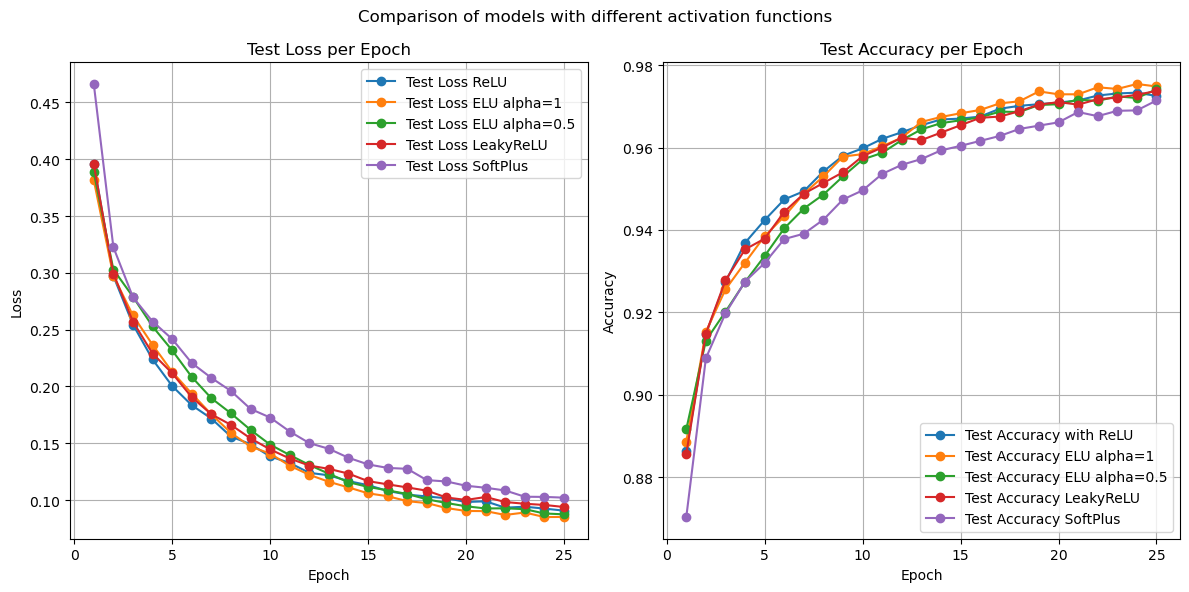

In [60]:
plt.figure(figsize=(12, 6))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, len(test_losses_relu) + 1), test_losses_relu, marker='o', label='Test Loss ReLU')
# plt.plot(range(1, len(test_losses_relu_bn) + 1), test_losses_relu_bn, marker='o', label='Test Loss with ReLU and BatchNorm')
plt.plot(range(1, len(test_losses_elu) + 1), test_losses_elu, marker='o', label='Test Loss ELU alpha=1')
plt.plot(range(1, len(test_losses_elu1) + 1), test_losses_elu1, marker='o', label='Test Loss ELU alpha=0.5')
plt.plot(range(1, len(test_losses_leaky) + 1), test_losses_leaky, marker='o', label='Test Loss LeakyReLU')
plt.plot(range(1, len(test_losses_softplus) + 1), test_losses_softplus, marker='o', label='Test Loss SoftPlus')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss per Epoch')
# plt.yscale('log')
plt.grid(True)
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(1, len(test_accuracies_relu) + 1), test_accuracies_relu, marker='o',  label='Test Accuracy with ReLU')
# plt.plot(range(1, len(test_accuracies_relu_bn) + 1), test_accuracies_relu_bn, marker='o',  label='Test Accuracy with ReLU and BatchNorm')
plt.plot(range(1, len(test_accuracies_elu) + 1), test_accuracies_elu, marker='o',  label='Test Accuracy ELU alpha=1')
plt.plot(range(1, len(test_accuracies_elu1) + 1), test_accuracies_elu1, marker='o',  label='Test Accuracy ELU alpha=0.5')
plt.plot(range(1, len(test_accuracies_leaky) + 1), test_accuracies_leaky, marker='o',  label='Test Accuracy LeakyReLU')
plt.plot(range(1, len(test_accuracies_softplus) + 1), test_accuracies_softplus, marker='o', label='Test Accuracy SoftPlus')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy per Epoch')
# plt.yscale('log')
plt.grid(True)
plt.legend()
plt.suptitle('Comparison of models with different activation functions')
plt.tight_layout()

plt.show()

**Функции активации:**
* Видно, что различные функции активации влияют на скорость сходимости, например SoftPlus и ELU дают меньшую скорость сходимости по сравнению с ReLU и LeakyReLU
* SoftPlus и ELU более сложные в вычислениях, хотя получаемая кривая обучения получается более гладкая нежели с ReLU или LeakyReLU
* Считается что ELU обладает более высокой скоростью сходимости, но в данном случае получаем противоположный результат. При изменении альфа, в данном случае, практически ничего не меняется.

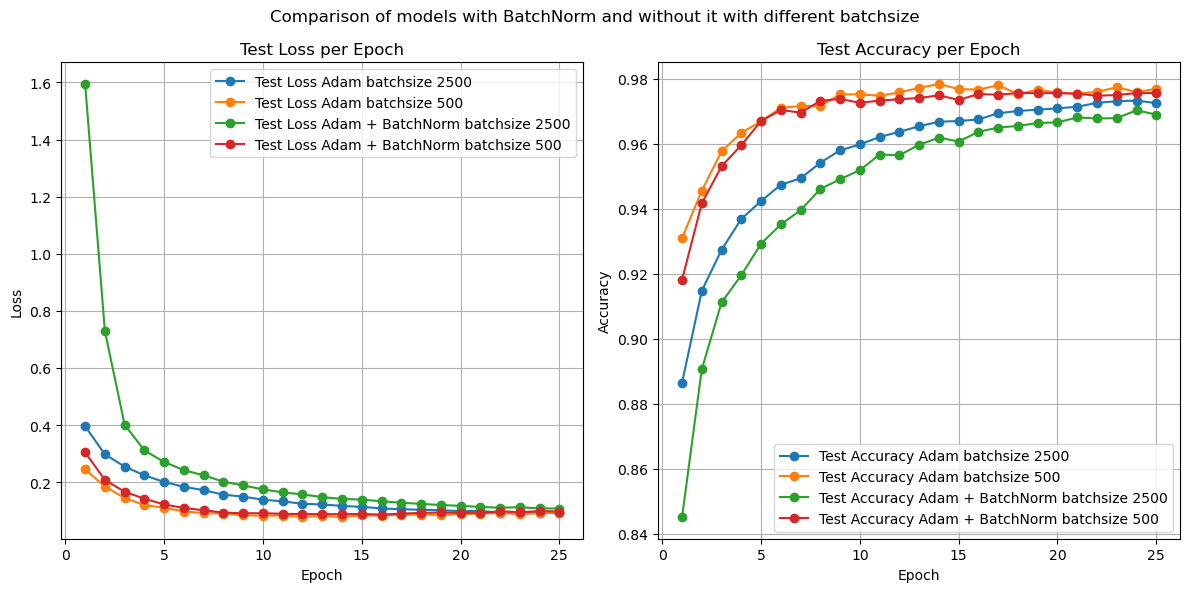

In [61]:
plt.figure(figsize=(12, 6))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, len(test_losses_relu) + 1), test_losses_relu, marker='o', label='Test Loss Adam batchsize 2500')
plt.plot(range(1, len(test_losses_relu3) + 1), test_losses_relu3, marker='o', label='Test Loss Adam batchsize 500')
plt.plot(range(1, len(test_losses_relu_bn) + 1), test_losses_relu_bn, marker='o', label='Test Loss Adam + BatchNorm batchsize 2500')
plt.plot(range(1, len(test_losses_relu_bn1) + 1), test_losses_relu_bn1, marker='o', label='Test Loss Adam + BatchNorm batchsize 500')
# plt.plot(range(1, len(test_losses_relu_sgd) + 1), test_losses_relu_sgd, marker='o', label='Test Loss SGD')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss per Epoch')
plt.grid(True)
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(1, len(test_accuracies_relu) + 1), test_accuracies_relu, marker='o', label='Test Accuracy Adam batchsize 2500')
plt.plot(range(1, len(test_accuracies_relu3) + 1), test_accuracies_relu3, marker='o', label='Test Accuracy Adam batchsize 500')
plt.plot(range(1, len(test_accuracies_relu_bn) + 1), test_accuracies_relu_bn, marker='o',  label='Test Accuracy Adam + BatchNorm batchsize 2500')
plt.plot(range(1, len(test_accuracies_relu_bn1) + 1), test_accuracies_relu_bn1, marker='o',  label='Test Accuracy Adam + BatchNorm batchsize 500')
# plt.plot(range(1, len(test_accuracies_relu_sgd) + 1), test_accuracies_relu_sgd, marker='o',label='Test Accuracy SGD' )
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy per Epoch')
plt.grid(True)
plt.legend()
plt.suptitle('Comparison of models with BatchNorm and without it with different batchsize')
plt.tight_layout()

plt.show()

**BatchNormalisation**
* Написано, что BatchNorm улучшает численную сходимость. В данном случае в результате экспериментов с шагом обучения, был момент, когда происходило переполнение градиента (взрыв) и применение BatchNorm помогло справится с этой проблемой.
* В данном случае получается небольшое различие с применением BatchNorm и без, но в итоге обе модели сходятся практически к одному значению accuracy.
* Из минусов можно отметить зависимость от размера бача и наличие дополнительных вычислений.
* Размер бача влияет на скорость сходимости, и на стабильность кривой обучения, с большим размером бача получается меньшее количество колебаний в процессе обучения

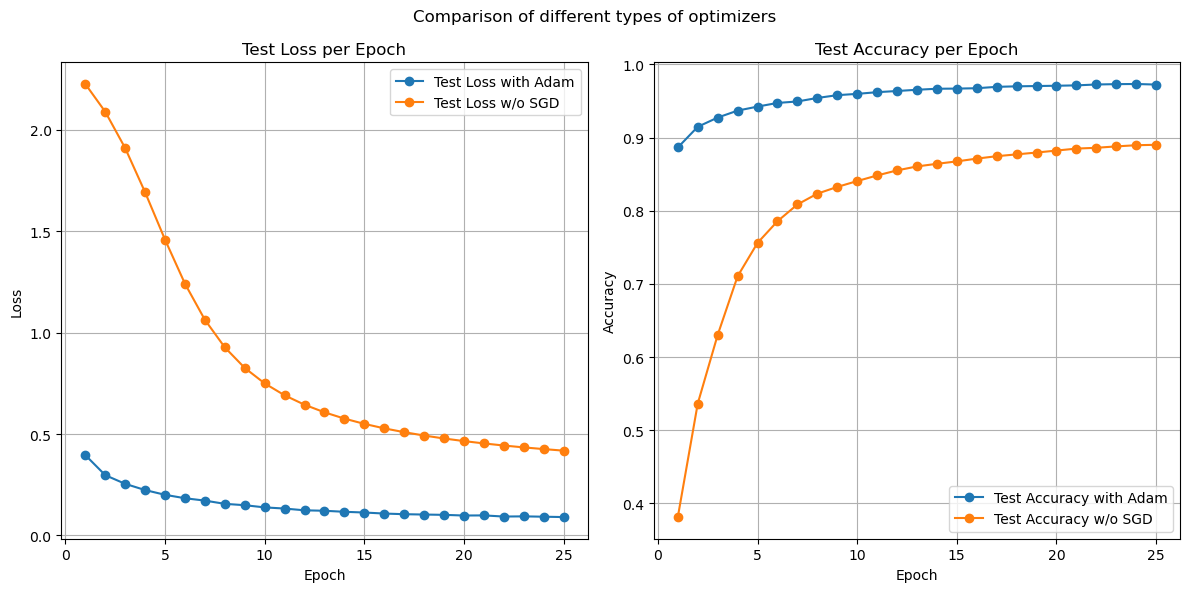

In [62]:
plt.figure(figsize=(12, 6))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, len(test_losses_relu) + 1), test_losses_relu, marker='o', label='Test Loss with Adam')
# plt.plot(range(1, len(test_losses_relu1) + 1), test_losses_relu1, marker='o', label='Test Loss w/o BatchNorm Adam')
plt.plot(range(1, len(test_losses_relu_sgd) + 1), test_losses_relu_sgd, marker='o', label='Test Loss w/o SGD')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss per Epoch')
plt.grid(True)
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(1, len(test_accuracies_relu) + 1), test_accuracies_relu, marker='o', label='Test Accuracy with Adam')
# plt.plot(range(1, len(test_accuracies_relu1) + 1), test_accuracies_relu1, marker='o',  label='Test Accuracy w/o BatchNorm Adam')
plt.plot(range(1, len(test_accuracies_relu_sgd) + 1), test_accuracies_relu_sgd, marker='o',label='Test Accuracy w/o SGD' )
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy per Epoch')
plt.grid(True)
plt.legend()
plt.suptitle('Comparison of different types of optimizers')
plt.tight_layout()

plt.show()

**Различные оптимизаторы**
* SGD медленнее сходится и сходится к более высокому значению лосса нежели Adam
* Adam выходит на плато по точности приблизительно за 15 эпох, в то время как accuracy у SGD все еще растет, но на более низких значениях и за 25 эпох не достигает показателей Adam. 

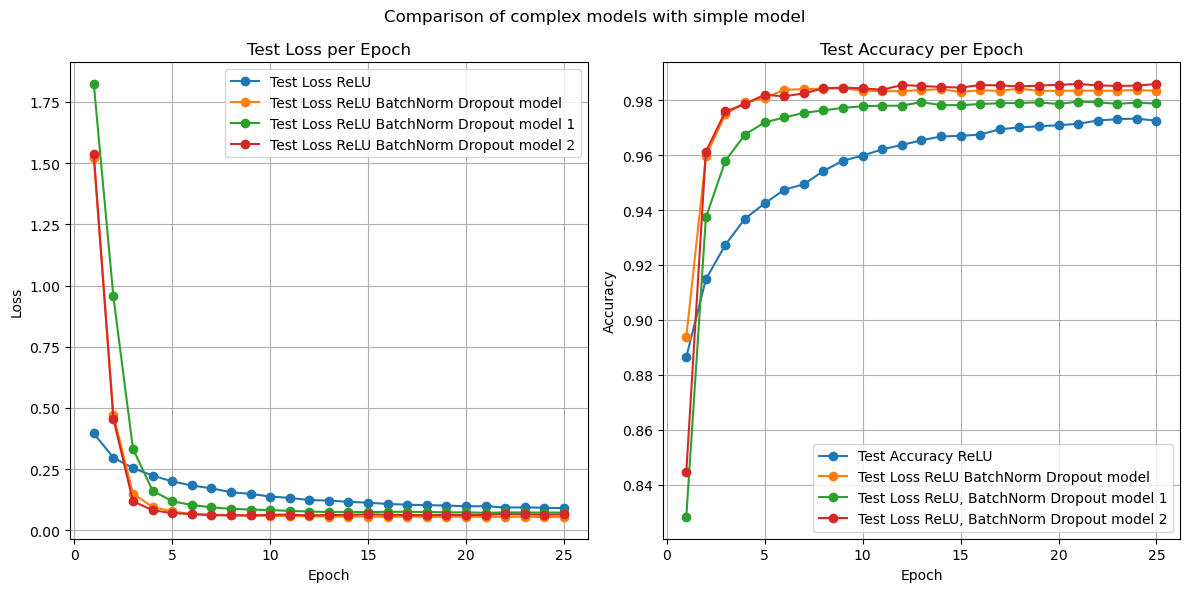

In [65]:
plt.figure(figsize=(12, 6))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, len(test_losses_relu) + 1), test_losses_relu, marker='o', label='Test Loss ReLU')
# plt.plot(range(1, len(test_losses_relu_bn) + 1), test_losses_relu_bn, marker='o', label='Test Loss with ReLU and BatchNorm')
plt.plot(range(1, len(test_losses_final) + 1), test_losses_final, marker='o', label='Test Loss ReLU BatchNorm Dropout model')
plt.plot(range(1, len(test_losses_final1) + 1), test_losses_final1, marker='o', label='Test Loss ReLU BatchNorm Dropout model 1')
plt.plot(range(1, len(test_losses_final2) + 1), test_losses_final2, marker='o', label='Test Loss ReLU BatchNorm Dropout model 2')



plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss per Epoch')
# plt.yscale('log')
plt.grid(True)
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(1, len(test_accuracies_relu) + 1), test_accuracies_relu, marker='o',  label='Test Accuracy ReLU')
# plt.plot(range(1, len(test_accuracies_relu_bn) + 1), test_accuracies_relu_bn, marker='o',  label='Test Accuracy with ReLU and BatchNorm')
plt.plot(range(1, len(test_accuracies_final) + 1), test_accuracies_final, marker='o', label='Test Loss ReLU BatchNorm Dropout model')
plt.plot(range(1, len(test_accuracies_final1) + 1), test_accuracies_final1, marker='o', label='Test Loss ReLU, BatchNorm Dropout model 1')
plt.plot(range(1, len(test_accuracies_final2) + 1), test_accuracies_final2, marker='o', label='Test Loss ReLU, BatchNorm Dropout model 2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy per Epoch')
# plt.yscale('log')
plt.grid(True)
plt.legend()
plt.suptitle('Comparison of complex models with simple model')
plt.tight_layout()

plt.show()

**Сравнение простой модели со сложными**

По графикам видно что более сложные модели выходят на более высокий уровень accuracy. Однако более сильное увеличение сложности модели не дает существенного увеличение accuracy. 
Хотя если смотреть численные значения, то самое высокое значение accuracy полученно с модели с самым большим количеством слоев.

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [56]:
# Your answer goes here. ################################################

# ответы под графиками

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [57]:
# Your code goes here. ################################################

# ответы под графиками

Print here your accuracy on test set. It should be around 90%.

In [68]:
print("Accuracy для обученных моделей")
labels = ["ReLU", "ELU", "SoftPlus", "LeakyReLU", "ReLU BatchNorm", "ReLU SGD", "ReLU BatchNorm Dropout model", "ReLU BatchNorm Dropout model 1", "ReLU BatchNorm Dropout model 2"]
models = [
    trained_model_relu,
    trained_model_elu,
    trained_model_softplus,
    trained_model_leaky,
    trained_model_relu_bn,
    trained_model_relu_sgd,
    trained_model_final,
    trained_model_final1,
    trained_model_final2]
for model, text in zip(models, labels):
    test_predict = model.forward(X_val)
    accuracy = np.mean(np.argmax(test_predict, axis=1) == np.argmax(y_val, axis=1))
    print(f"accuracy: {accuracy:.4f}   {text}")

Accuracy для обученных моделей
accuracy: 0.9725   ReLU
accuracy: 0.9748   ELU
accuracy: 0.9714   SoftPlus
accuracy: 0.9737   LeakyReLU
accuracy: 0.9690   ReLU BatchNorm
accuracy: 0.8902   ReLU SGD
accuracy: 0.9834   ReLU BatchNorm Dropout model
accuracy: 0.9788   ReLU BatchNorm Dropout model 1
accuracy: 0.9859   ReLU BatchNorm Dropout model 2


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset


X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_train = X_train.view(-1, 784)  
X_val = X_val.view(-1, 784)


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)



class MNISTLinearClassifier(nn.Module):
    def __init__(self):
        super(MNISTLinearClassifier, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = MNISTLinearClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 20
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")


model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, target in val_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        _, target_labels = torch.max(target, 1)
        total += target.size(0)
        correct += (predicted == target_labels).sum().item()

    print(f"Test Accuracy: {(100 * correct / total):.2f}%")

Epoch [1/20], Step [100/938], Loss: 0.4597
Epoch [1/20], Step [200/938], Loss: 0.3228
Epoch [1/20], Step [300/938], Loss: 0.2792
Epoch [1/20], Step [400/938], Loss: 0.3035
Epoch [1/20], Step [500/938], Loss: 0.1494
Epoch [1/20], Step [600/938], Loss: 0.1195
Epoch [1/20], Step [700/938], Loss: 0.1101
Epoch [1/20], Step [800/938], Loss: 0.0749
Epoch [1/20], Step [900/938], Loss: 0.1277
Epoch [2/20], Step [100/938], Loss: 0.1142
Epoch [2/20], Step [200/938], Loss: 0.0692
Epoch [2/20], Step [300/938], Loss: 0.0118
Epoch [2/20], Step [400/938], Loss: 0.1949
Epoch [2/20], Step [500/938], Loss: 0.1343
Epoch [2/20], Step [600/938], Loss: 0.0596
Epoch [2/20], Step [700/938], Loss: 0.1411
Epoch [2/20], Step [800/938], Loss: 0.0755
Epoch [2/20], Step [900/938], Loss: 0.0544
Epoch [3/20], Step [100/938], Loss: 0.0393
Epoch [3/20], Step [200/938], Loss: 0.1171
Epoch [3/20], Step [300/938], Loss: 0.0301
Epoch [3/20], Step [400/938], Loss: 0.0076
Epoch [3/20], Step [500/938], Loss: 0.0116
Epoch [3/20

С помощью PyTorch получаем модель сопоставимую по точности с нашей моделью. 
* PyTorch accuracy: **0.9827**
* Моя самая сложная модель с 5 линейными слоями accuracy: **0.985**